<a href="https://colab.research.google.com/github/CharlotteStevensBristol/MathBiology-Neuron-Project/blob/main/Cognitive_AI_Coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title
# Uncomment following lines to install
! pip install gymnasium   # Install gym
! git clone https://github.com/gyyang/neurogym.git  # Install neurogym
! pip install neurogym
%cd neurogym
# ! pip install -e .


fatal: destination path 'neurogym' already exists and is not an empty directory.
/content/neurogym/neurogym


### Import packages

In [ ]:
# @title
import os
from pathlib import Path
import json
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import gymnasium as gym
import neurogym as ngym

device = 'cuda' if torch.cuda.is_available() else 'cpu'

### General analysis - set up functions for reusable charts

In [ ]:
# @title
def get_modelpath(envid, model_tag):
    """
    Create a unique directory per (task, model).

    model_tag examples:
        "task1_lstm"
        "task1_lstm_plusl2"
        "task2_lstm"
        "task2_lstm_plusl2"
    """
    path = Path('.') / 'files' / envid / model_tag
    os.makedirs(path, exist_ok=True)
    return path

activity_by_model = {}
losses_by_model = {}
nets_by_model = {}


In [ ]:
# @title
# CHART FUNCTIONS analysis_average_activity
def analysis_average_activity(activity_by_m, info, config, savepath):
    # t_plot = np.arange(activity_by_m.shape[1]) * config['dt']
    T = activity_by_m.shape[1]
    t_plot = np.arange(T) * config['dt']
    mean_act = activity_by_m.mean(axis=0).mean(axis=-1)

    plt.figure(figsize=(4, 3))  # larger figure
    plt.plot(t_plot, mean_act, linewidth=2)

    # Title + labels with nicer formatting
    plt.title("Average Population Activity", fontsize=12)
    plt.xlabel("Time (ms)", fontsize=10)
    plt.ylabel("Mean Activity", fontsize=10)

    # Cleaner tick formatting
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)

    # Remove top & right spines
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.tight_layout()

    # Optional save
    if savepath is not None:
      fname = os.path.join(savepath, "avg_population_activity.png")
      plt.savefig(fname, dpi=300, bbox_inches="tight")

    plt.show()



In [ ]:
# @title
# CHART FUNCTIONS
def get_conditions(info):
    """Get a list of task conditions to plot."""
    # This condition's unique value should be less than 5
    new_conditions = list()
    for c in info.columns:
        try:
            n_cond = len(pd.unique(info[c]))
            if 1 < n_cond < 5:
            #if n_cond >= 2:
                new_conditions.append(c)
        except TypeError:
            pass

    return new_conditions



In [ ]:
# @title
# CHART FUNCTIONS analysis_activity_by_condition
def analysis_activity_by_condition(activity, info, config, savepath=None):
    conditions = get_conditions(info)

    for condition in conditions:
        values = pd.unique(info[condition])
        t_plot = np.arange(activity.shape[1]) * config['dt']

        plt.figure(figsize=(4, 3))

        for value in values:
            a = activity[info[condition] == value]
            mean_act = a.mean(axis=0).mean(axis=-1)
            plt.plot(t_plot, mean_act, linewidth=2, label=str(value))

        # Titles & labels
        plt.title(f"Average Population Activity by {condition}", fontsize=12)
        plt.xlabel("Time (ms)", fontsize=10)
        plt.ylabel("Mean activity", fontsize=10)

        # Ticks
        plt.xticks(fontsize=9)
        plt.yticks(fontsize=9)

        # Legend
        plt.legend(title=condition, fontsize=9, title_fontsize=9,
                   loc="center left", bbox_to_anchor=(1.0, 0.5))

        # Remove clutter
        ax = plt.gca()
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        plt.tight_layout()

        # Optional save
        if savepath is not None:
            fname = f"{savepath}/avg_activity_by_{condition}.png"
            plt.savefig(fname, dpi=300, bbox_inches="tight")

        plt.show()



In [ ]:
# @title
# CHART FUNCTIONS
def analysis_example_units_by_condition(activity, info, config, savepath=None):
    conditions = get_conditions(info)
    if len(conditions) < 1:
        return

    example_ids = np.array([0, 1])   # choose units to visualise

    for example_id in example_ids:
        example_activity = activity[:, :, example_id]

        fig, axes = plt.subplots(
            len(conditions), 1,
            figsize=(4, 2.2 * len(conditions)),
            sharex=True
        )

        t_plot = np.arange(activity.shape[1]) * config['dt']

        # Loop through task conditions (ground_truth, correct, choice…)
        for i, condition in enumerate(conditions):
            ax = axes[i]
            values = pd.unique(info[condition])

            for value in values:
                a = example_activity[info[condition] == value]
                ax.plot(t_plot, a.mean(axis=0),
                        linewidth=2,
                        label=str(value))

            # Labels and legend
            ax.set_ylabel("Activity", fontsize=10)
            ax.legend(title=condition,
                      fontsize=9,
                      title_fontsize=9,
                      loc="center left",
                      bbox_to_anchor=(1.0, 0.5))

            # Remove clutter
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)
            ax.tick_params(labelsize=9)

            if i == 0:
                ax.set_title(f"Unit {example_id + 1}",
                             fontsize=12,
                             pad=10)

        axes[-1].set_xlabel("Time (ms)", fontsize=10)
        plt.tight_layout()

        # Save figure if a path is provided
        if savepath is not None:
            fname = f"{savepath}/unit_{example_id+1}_activity_by_condition.png"
            plt.savefig(fname, dpi=300, bbox_inches="tight")

        plt.show()

In [ ]:
# @title
# CHART FUNCTIONS
def analysis_pca_by_condition(activity, info, config, savepath=None):
    # Reshape activity to (N_trial * N_time, N_neuron)
    activity_reshape = activity.reshape(-1, activity.shape[-1])

    pca = PCA(n_components=2)
    pca.fit(activity_reshape)

    conditions = get_conditions(info)

    for condition in conditions:
        values = pd.unique(info[condition])

        plt.figure(figsize=(4, 4))
        ax = plt.gca()

        for value in values:
            # Average trajectories over trials
            a = activity[info[condition] == value].mean(axis=0)
            a_pca = pca.transform(a)  # (N_time, 2)

            ax.plot(a_pca[:, 0], a_pca[:, 1],
                    linewidth=2,
                    label=str(value))

            # Optional: mark start and end points
            ax.scatter(a_pca[0, 0], a_pca[0, 1], s=30, marker='o')
            ax.scatter(a_pca[-1, 0], a_pca[-1, 1], s=40, marker='x')

        # Labels & title
        ax.set_title(f"PCA Trajectories by {condition}", fontsize=12)
        ax.set_xlabel("PC 1", fontsize=10)
        ax.set_ylabel("PC 2", fontsize=10)

        # Ticks
        ax.tick_params(labelsize=9)

        # Legend
        ax.legend(title=condition,
                  fontsize=9,
                  title_fontsize=9,
                  loc="center left",
                  bbox_to_anchor=(1.0, 0.5))

        # Remove clutter
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        ax.set_aspect("equal", adjustable="box")

        plt.tight_layout()

        # Save figure
        if savepath is not None:
            fname = f"{savepath}/pca_trajectories_by_{condition}.png"
            plt.savefig(fname, dpi=300, bbox_inches="tight")

        plt.show()

In [ ]:
# @title
def plot_training_loss(losses_by_model, model_tags, xmax=None):
    plt.figure()
    for tag in model_tags:
        losses = losses_by_model[tag]
        x = np.arange(1, len(losses) + 1)
        if xmax is not None:
            mask = x <= xmax
            x = x[mask]
            losses = np.array(losses)[mask]
        plt.plot(x, losses, label=tag)
    plt.xlabel("Batch")
    plt.ylabel("Training loss")
    plt.legend()
    plt.title("Training loss over time")
    plt.show()


### Define network

In [ ]:
# @title
# LSTM
class LSTM_plain(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, hidden = self.lstm(x)
        x = self.linear(out)
        return x, out


### **TASK 1 LSTM**


### TASK 1 LSTM - Train network

In [ ]:
# @title
dataset = None
net = None
activity = None
info = None
torch.cuda.empty_cache()

envid = 'PerceptualDecisionMaking-v0'
model_tag = "task1_lstm"
figpath = "./task 1 vanilla lstm"
os.makedirs(figpath, exist_ok=True)

modelpath = get_modelpath(envid, model_tag)
config = {
    'dt': 100,
    'hidden_size': 64,
    'lr': 1e-2,
    'batch_size': 16,
    'seq_len': 100,
    'envid': envid,
}

env_kwargs = {'dt': config['dt']}
config['env_kwargs'] = env_kwargs

# Save config
with open(modelpath / 'config.json', 'w') as f:
    json.dump(config, f)

# Make supervised dataset
dataset = ngym.Dataset(
    envid,
    env_kwargs=env_kwargs,
    batch_size=config['batch_size'],
    seq_len=config['seq_len']
)

env = dataset.env
act_size = env.action_space.n

# Train network
net = LSTM_plain(
    input_size=env.observation_space.shape[0],
    hidden_size=config['hidden_size'],
    output_size=act_size)
net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=config['lr'])

print('Training task ', envid)

running_loss = 0.0
losses = []

for i in range(2000):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float).to(device)
    labels = torch.from_numpy(labels.flatten()).type(torch.long).to(device)
    optimizer.zero_grad()

    outputs, activity = net(inputs)

    # task_loss = criterion(outputs.view(-1, act_size), labels)
    task_loss = criterion(outputs.view(-1, act_size), labels)

    #logits, activity = net(inputs)
    rate_loss = activity.pow(2).mean()

    loss = task_loss
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    running_loss += loss.item()
    if i % 200 == 199:
        print(
            '{:d} loss: {:0.5f} | task loss: {:0.5f} | rate: {:0.5f}'.format(i + 1,
                running_loss/200,
                loss.item(),
                rate_loss.item()
            )
        )
        running_loss = 0.0
        torch.save(net.state_dict(), modelpath / 'net.pth')

# STORE RESULTS ONCE, AFTER TRAINING
losses_by_model[model_tag] = np.array(losses)
nets_by_model[model_tag] = net

print('Finished Training')


/usr/local/lib/python3.12/dist-packages/gymnasium/envs/registration.py:481: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['paper_link', 'paper_name', 'tags']
  logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.seed to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.seed` for environment variables or `env.get_wrapper_attr('seed')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.new_trial to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.new_trial` for environment variables or `env.get_wrapper_attr('new_trial')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/core.py:311: UserWarning: WARN: e

Training task  PerceptualDecisionMaking-v0
200 loss: 0.13076 | task loss: 0.03016 | rate: 0.19026
400 loss: 0.02472 | task loss: 0.01961 | rate: 0.15392
600 loss: 0.01254 | task loss: 0.01148 | rate: 0.15591
800 loss: 0.01195 | task loss: 0.00975 | rate: 0.14146
1000 loss: 0.01189 | task loss: 0.01215 | rate: 0.12290
1200 loss: 0.01136 | task loss: 0.01647 | rate: 0.11185
1400 loss: 0.01091 | task loss: 0.00975 | rate: 0.11819
1600 loss: 0.01084 | task loss: 0.01741 | rate: 0.10771
1800 loss: 0.01129 | task loss: 0.01670 | rate: 0.08800
2000 loss: 0.01036 | task loss: 0.01009 | rate: 0.09511
Finished Training


In [ ]:
# @title
def infer_test_timing(env):
    """Infer timing of environment for testing."""
    timing = {}
    for period in env.timing.keys():
        period_times = [env.sample_time(period) for _ in range(100)]
        timing[period] = np.median(period_times)
    return timing


### TASK 1 LSTM - Run network after training for analysis

In [ ]:
# @title
modelpath = get_modelpath(envid, model_tag)
with open(modelpath / 'config.json') as f:
    config = json.load(f)
env_kwargs = config['env_kwargs']

# Environment
env = gym.make(envid, **env_kwargs)
env.timing = infer_test_timing(env)
#env.reset()

# Instantiate the network and print information
with torch.no_grad():
    net = LSTM_plain(input_size=env.observation_space.shape[0],
              hidden_size=config['hidden_size'],
              output_size=env.action_space.n)
    net = net.to(device)
    net.load_state_dict(torch.load(modelpath / 'net.pth'))
    net.eval()

    perf = 0
    num_trial = 100

    activity = list()
    info = pd.DataFrame()

    for i in range(num_trial):
        env.new_trial()
        ob, gt = env.ob, env.gt
        inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
        action_pred, hidden = net(inputs)

        # Compute performance
        action_pred = action_pred.detach().numpy()
        choice = np.argmax(action_pred[-1, 0, :])
        correct = choice == gt[-1]

        # Log trial info
        trial_info = env.trial
        trial_info.update({'correct': correct, 'choice': choice})
        info = pd.concat([info, pd.DataFrame([trial_info])], ignore_index=True)

        # Log stimulus period activity
        activity.append(np.array(hidden)[:, 0, :])

    print('Average performance', np.mean(info['correct']))

activity = np.array(activity)
activity_by_model[model_tag] = activity

/usr/local/lib/python3.12/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.timing to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.timing` for environment variables or `env.get_wrapper_attr('timing')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.sample_time to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.sample_time` for environment variables or `env.get_wrapper_attr('sample_time')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.new_trial to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.new_trial` for environment variables or `env.get_wrapper_attr('new_tri

Average performance 0.94


### TASK 1 LSTM - Run charts

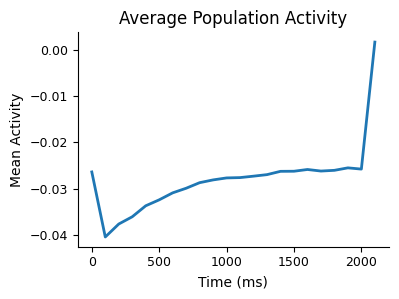

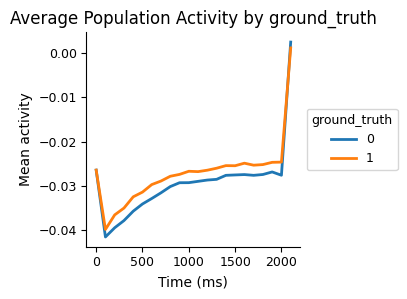

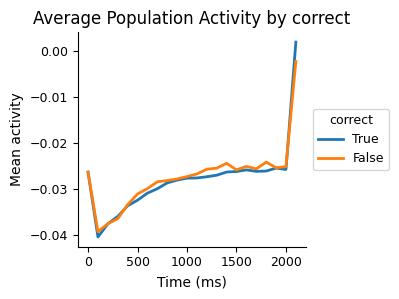

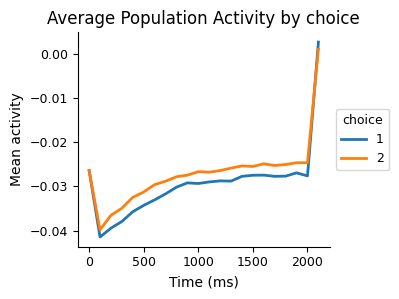

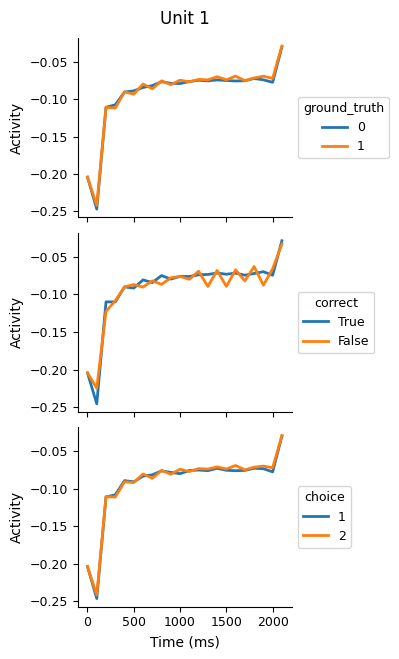

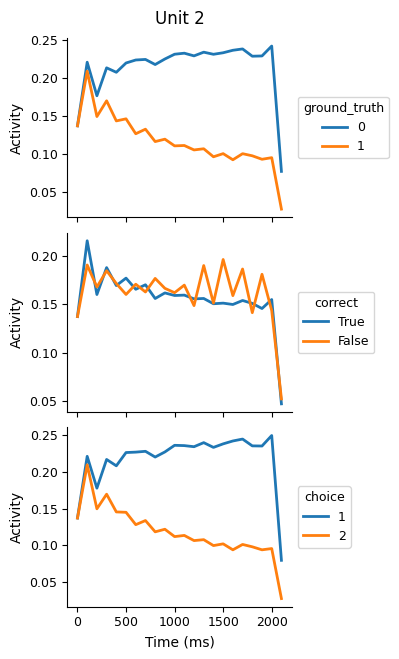

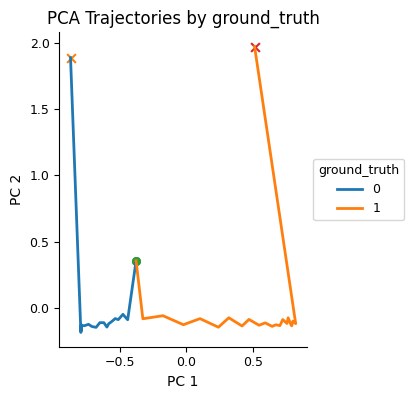

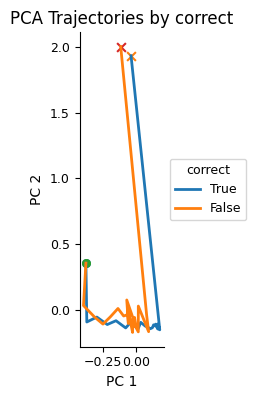

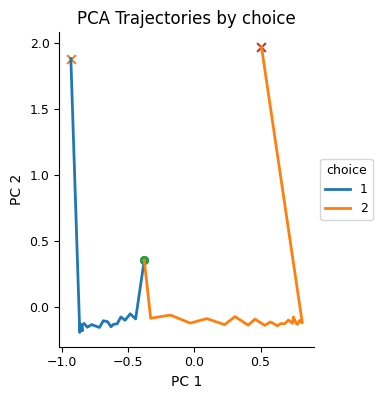

In [ ]:
# @title
# Run analysis charts
analysis_average_activity(activity_by_m=activity_by_model["task1_lstm"], info=info, config=config, savepath=figpath)

analysis_activity_by_condition(activity_by_model["task1_lstm"], info, config, savepath=figpath)

analysis_example_units_by_condition(activity_by_model["task1_lstm"], info, config, savepath=figpath)

analysis_pca_by_condition(activity_by_model["task1_lstm"], info, config, savepath=figpath)

### **TASK 1 LSTM with L2 regularisation**

### TASK 1 LSTM with L2 - Train network


In [ ]:
# @title
dataset = None
net = None
activity = None
hidden_activity = None
info = None
torch.cuda.empty_cache()

envid = 'PerceptualDecisionMaking-v0'
model_tag = "task1_lstm_plusL2"
figpath = "./task 1 lstm + L2/"
os.makedirs(figpath, exist_ok=True)

modelpath = get_modelpath(envid, model_tag)
config = {
    'dt': 100,
    'hidden_size': 64,
    'lr': 1e-2,
    'batch_size': 16,
    'seq_len': 100,
    'envid': envid,
    'lambda_rate': 1e-3,     # <- NEW regularisation strength
}

env_kwargs = {'dt': config['dt']}
config['env_kwargs'] = env_kwargs

# Save config
with open(modelpath / 'config.json', 'w') as f:
    json.dump(config, f)

# Make supervised dataset
dataset = ngym.Dataset(
    envid,
    env_kwargs=env_kwargs,
    batch_size=config['batch_size'],
    seq_len=config['seq_len']
)

env = dataset.env
act_size = env.action_space.n

# Train network
net = LSTM_plain(
    input_size=env.observation_space.shape[0],
    hidden_size=config['hidden_size'],
    output_size=act_size)
net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=config['lr'])

print('Training task ', envid)
print('Using firing-rate L2 regularisation (λ = {})'.format(config['lambda_rate']))

running_loss = 0.0
losses = []
for i in range(2000):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).float().to(device)
    labels = torch.from_numpy(labels.flatten()).long().to(device)
    optimizer.zero_grad()

    # Forward pass
    outputs, hidden_activity = net(inputs)

    # Task loss
    task_loss = criterion(outputs.view(-1, act_size), labels)

    # Firing-rate L2 regularisation
    rate_loss = hidden_activity.pow(2).mean()

    # Total loss - penalise high firing rate!
    loss = task_loss + config['lambda_rate'] * rate_loss   # <- NEW

    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    running_loss += loss.item()
    if i % 200 == 199:
        print(
            '{:d} loss: {:0.5f} | task: {:0.5f} | rate: {:0.5f}'.format(
                i + 1,
                running_loss / 200,
                task_loss.item(),
                rate_loss.item()
            )
        )
        running_loss = 0.0
        torch.save(net.state_dict(), modelpath / 'net.pth')

# STORE RESULTS ONCE, AFTER TRAINING
losses_by_model[model_tag] = np.array(losses)
nets_by_model[model_tag] = net

print('Finished Training (with firing-rate regularisation)')


/usr/local/lib/python3.12/dist-packages/gymnasium/envs/registration.py:481: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['paper_link', 'paper_name', 'tags']
  logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.seed to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.seed` for environment variables or `env.get_wrapper_attr('seed')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.new_trial to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.new_trial` for environment variables or `env.get_wrapper_attr('new_trial')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/core.py:311: UserWarning: WARN: e

Training task  PerceptualDecisionMaking-v0
Using firing-rate L2 regularisation (λ = 0.001)
200 loss: 0.13093 | task: 0.03014 | rate: 0.12762
400 loss: 0.03207 | task: 0.02897 | rate: 0.12821
600 loss: 0.01569 | task: 0.01313 | rate: 0.10492
800 loss: 0.01312 | task: 0.00763 | rate: 0.09993
1000 loss: 0.01167 | task: 0.01598 | rate: 0.09673
1200 loss: 0.01135 | task: 0.01177 | rate: 0.09706
1400 loss: 0.01086 | task: 0.00963 | rate: 0.09412
1600 loss: 0.01095 | task: 0.01353 | rate: 0.09238
1800 loss: 0.01107 | task: 0.01153 | rate: 0.08942
2000 loss: 0.01002 | task: 0.01326 | rate: 0.09093
Finished Training (with firing-rate regularisation)


In [ ]:
# @title
def infer_test_timing(env):
    """Infer timing of environment for testing."""
    timing = {}
    for period in env.timing.keys():
        period_times = [env.sample_time(period) for _ in range(100)]
        timing[period] = np.median(period_times)
    return timing


### TASK 1 LSTM with L2 - Run network after training for analysis

In [ ]:
# @title
modelpath = get_modelpath(envid, model_tag)
with open(modelpath / 'config.json') as f:
    config = json.load(f)

env_kwargs = config['env_kwargs']

# Run network to get activity and info
# Environment
env = gym.make(envid, **env_kwargs)
env.timing = infer_test_timing(env)
env.reset()

# Instantiate the network and print information
with torch.no_grad():
    net = LSTM_plain(input_size=env.observation_space.shape[0],
              hidden_size=config['hidden_size'],
              output_size=env.action_space.n)
    net = net.to(device)
    net.load_state_dict(torch.load(modelpath / 'net.pth'))

    perf = 0
    num_trial = 100

    activity = list()
    info = pd.DataFrame()

    for i in range(num_trial):
        env.new_trial()
        ob, gt = env.ob, env.gt
        inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
        action_pred, hidden = net(inputs)

        # Compute performance
        action_pred = action_pred.detach().numpy()
        choice = np.argmax(action_pred[-1, 0, :])
        correct = choice == gt[-1]

        # Log trial info
        trial_info = env.trial
        trial_info.update({'correct': correct, 'choice': choice})
        info = pd.concat([info, pd.DataFrame([trial_info])], ignore_index=True)

        # Log stimulus period activity
        activity.append(np.array(hidden)[:, 0, :])

    print('Average performance', np.mean(info['correct']))

activity = np.array(activity)
activity_by_model[model_tag] = activity

/usr/local/lib/python3.12/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.timing to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.timing` for environment variables or `env.get_wrapper_attr('timing')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.sample_time to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.sample_time` for environment variables or `env.get_wrapper_attr('sample_time')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.new_trial to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.new_trial` for environment variables or `env.get_wrapper_attr('new_tri

Average performance 0.87


### TASK 1 LSTM with L2 - Run charts

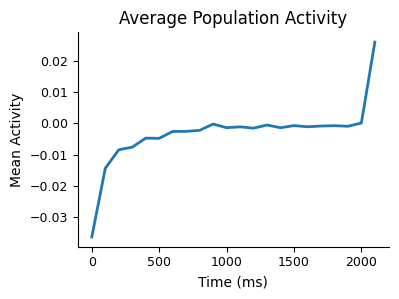

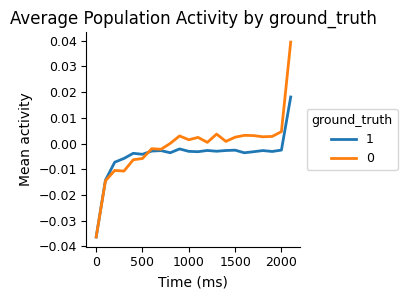

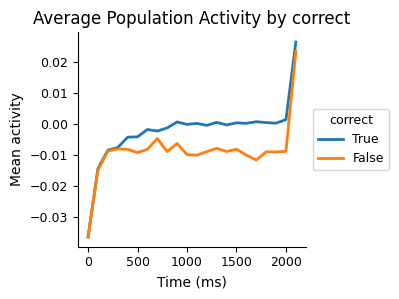

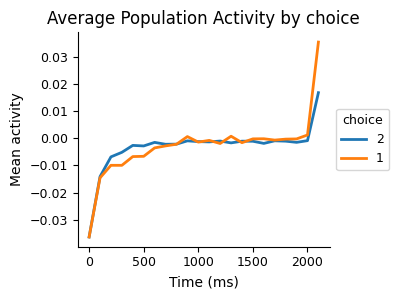

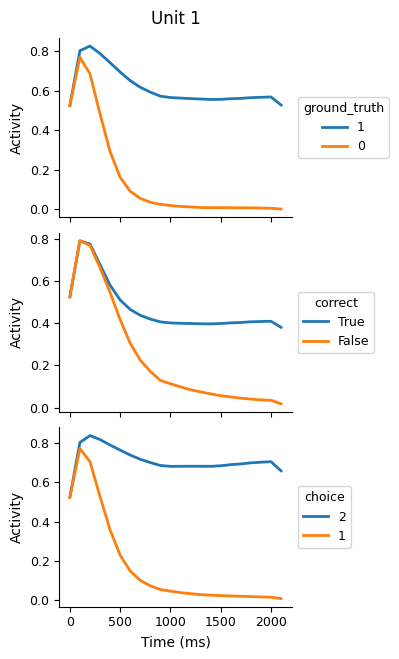

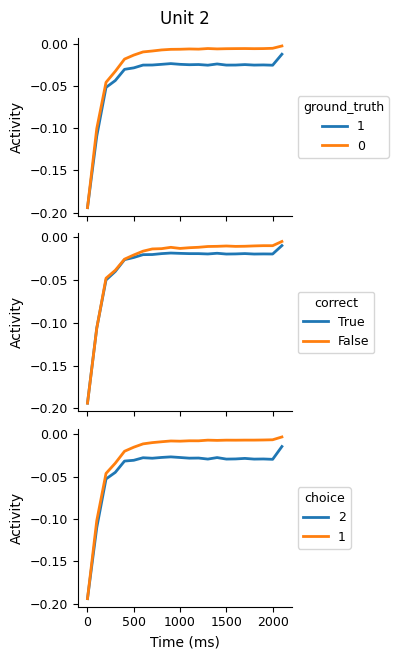

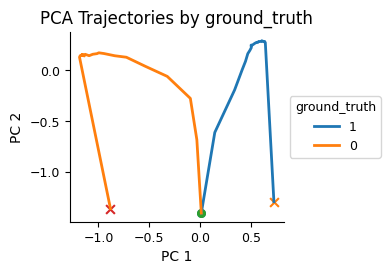

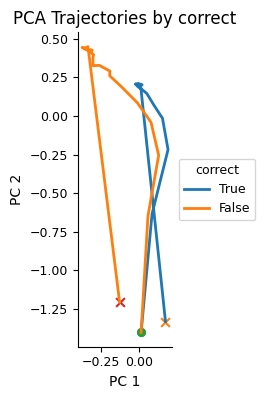

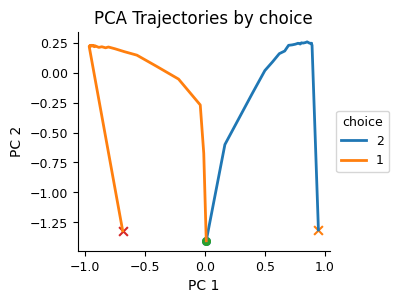

In [ ]:
# @title
# Run analysis charts
analysis_average_activity(activity_by_m=activity_by_model["task1_lstm_plusL2"], info=info, config=config, savepath=figpath)

analysis_activity_by_condition(activity_by_model["task1_lstm_plusL2"], info, config, savepath=figpath)

analysis_example_units_by_condition(activity_by_model["task1_lstm_plusL2"], info, config, savepath=figpath)

analysis_pca_by_condition(activity_by_model["task1_lstm_plusL2"], info, config, savepath=figpath)

### **TASK 2 LSTM**

### TASK 2 LSTM - Train network


In [ ]:
# @title
dataset = None
net = None
activity = None
info = None
torch.cuda.empty_cache()

envid = 'PerceptualDecisionMakingDelayResponse-v0'
model_tag = "task2_lstm"
figpath = "./task 2 vanilla lstm"
os.makedirs(figpath, exist_ok=True)

modelpath = get_modelpath(envid, model_tag)
config = {
    'dt': 100,
    'hidden_size': 64,
    'lr': 1e-2,
    'batch_size': 16,
    'seq_len': 100,
    'envid': envid,
}

env_kwargs = {'dt': config['dt']}
config['env_kwargs'] = env_kwargs

# Save config
with open(modelpath / 'config.json', 'w') as f:
    json.dump(config, f)

# Make supervised dataset
dataset = ngym.Dataset(
    envid,
    env_kwargs=env_kwargs,
    batch_size=config['batch_size'],
    seq_len=config['seq_len'])

env = dataset.env
act_size = env.action_space.n
# Train network
net = LSTM_plain(input_size=env.observation_space.shape[0],
          hidden_size=config['hidden_size'],
          output_size=act_size)
net = net.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = torch.optim.Adam(net.parameters(), lr=config['lr'])

print('Training task ', envid)

running_loss = 0.0
losses = []
for i in range(2000):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float).to(device)
    labels = torch.from_numpy(labels.flatten()).type(torch.long).to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs, _ = net(inputs)

    task_loss = criterion(outputs.view(-1, act_size), labels)
    rate_loss = outputs.pow(2).mean()
    loss = task_loss
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    # print statistics
    running_loss += loss.item()
    if i % 200 == 199:
      print(
        '{:d} loss: {:0.5f} | task: {:0.5f} | rate: {:0.5f}'.format(
                i + 1,
                running_loss / 200,
                task_loss.item(),
                rate_loss.item()
        )
      )
      running_loss = 0.0
      torch.save(net.state_dict(), modelpath / 'net.pth')

# STORE RESULTS ONCE, AFTER TRAINING
losses_by_model[model_tag] = np.array(losses)
nets_by_model[model_tag] = net

print('Finished Training')

/usr/local/lib/python3.12/dist-packages/gymnasium/envs/registration.py:481: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['paper_link', 'paper_name', 'tags']
  logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.seed to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.seed` for environment variables or `env.get_wrapper_attr('seed')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.new_trial to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.new_trial` for environment variables or `env.get_wrapper_attr('new_trial')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/core.py:311: UserWarning: WARN: e

Training task  PerceptualDecisionMakingDelayResponse-v0
200 loss: 0.29479 | task: 0.26894 | rate: 31.13869
400 loss: 0.24574 | task: 0.25935 | rate: 36.33091
600 loss: 0.24594 | task: 0.25234 | rate: 41.60320
800 loss: 0.24463 | task: 0.23192 | rate: 42.47866
1000 loss: 0.24604 | task: 0.23983 | rate: 46.73350
1200 loss: 0.24807 | task: 0.25911 | rate: 43.42810
1400 loss: 0.24678 | task: 0.25127 | rate: 52.81247
1600 loss: 0.24592 | task: 0.24202 | rate: 58.50687
1800 loss: 0.24588 | task: 0.23343 | rate: 55.72901
2000 loss: 0.24488 | task: 0.26144 | rate: 63.69314
Finished Training


In [ ]:
# @title
def infer_test_timing(env):
    """Infer timing of environment for testing."""
    timing = {}
    for period in env.timing.keys():
        period_times = [env.sample_time(period) for _ in range(100)]
        timing[period] = np.median(period_times)
    return timing


### TASK 2 LSTM - Run network after training for analysis

In [ ]:
# @title
modelpath = get_modelpath(envid, model_tag)
with open(modelpath / 'config.json') as f:
    config = json.load(f)

env_kwargs = config['env_kwargs']

# Environment
env = gym.make(envid, **env_kwargs)
env.timing = infer_test_timing(env)
env.reset()

# Instantiate the network and print information
with torch.no_grad():
    net = LSTM_plain(input_size=env.observation_space.shape[0],
              hidden_size=config['hidden_size'],
              output_size=env.action_space.n)
    net = net.to(device)
    net.load_state_dict(torch.load(modelpath / 'net.pth'))

    perf = 0
    num_trial = 100

    activity = list()
    info = pd.DataFrame()

    for i in range(num_trial):
        env.new_trial()
        ob, gt = env.ob, env.gt

        # inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
        inputs = torch.from_numpy(ob[:, np.newaxis, :]).float().to(device)

        action_pred, activity_t = net(inputs)

        # Compute performance
        action_pred = action_pred.detach().numpy()

        resp_idx = np.where(gt != -1)[0]
        t_dec = resp_idx[-1]
        choice = action_pred[t_dec, 0].argmax()
        # choice = np.argmax(action_pred[-1, 0, :])
        #correct = choice == gt[t_dec]
        correct = choice == gt[-1]

        # Log trial info
        trial_info = env.trial
        trial_info.update({'correct': correct, 'choice': choice})
        info = pd.concat([info, pd.DataFrame([trial_info])], ignore_index=True)

        # Log stimulus period activity (pad to fixed length to append in one object)
        # h = np.array(hidden)[:, 0, :]
        # h = activity_t.cpu().numpy()   # already (time, hidden)
        h = activity_t[:, 0, :].cpu().numpy()
        T =  h.shape[0]

        if i == 0:
            T_ref = T                            # reference length from first trial

        if T < T_ref:
            pad = np.zeros((T_ref - T, h.shape[1]), dtype=h.dtype)
            h = np.vstack([h, pad])
        elif T > T_ref:
            h = h[:T_ref]

        activity.append(h)

    print('Average performance', np.mean(info['correct']))

# # --- FORCE EQUAL TIME LENGTH ACROSS TRIALS ---
# min_T = min(a.shape[0] for a in activity)
# activity = [a[:min_T, :] for a in activity]
activity = np.array(activity)
activity_by_model[model_tag] = activity


/usr/local/lib/python3.12/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.timing to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.timing` for environment variables or `env.get_wrapper_attr('timing')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.sample_time to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.sample_time` for environment variables or `env.get_wrapper_attr('sample_time')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.new_trial to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.new_trial` for environment variables or `env.get_wrapper_attr('new_tri

Average performance 0.49


### TASK 2 LSTM - Run charts

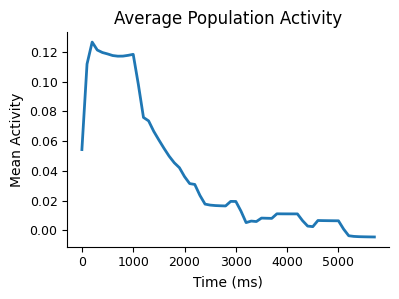

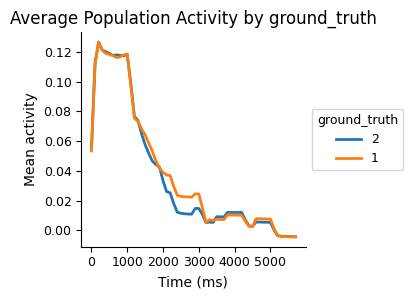

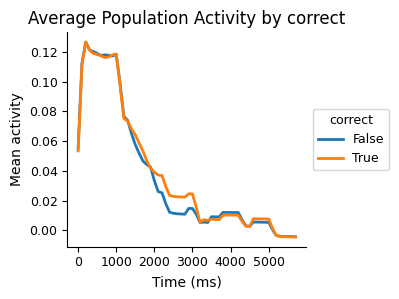

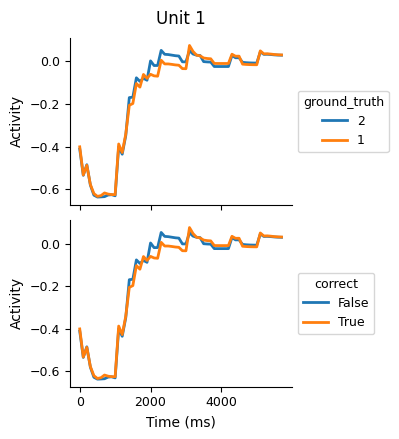

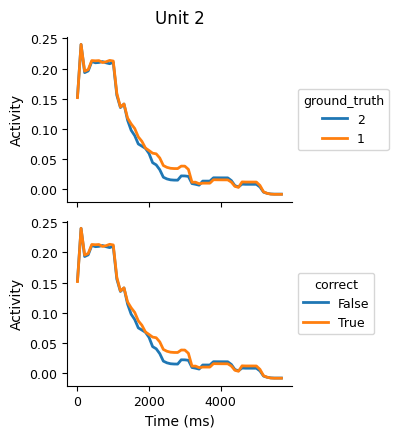

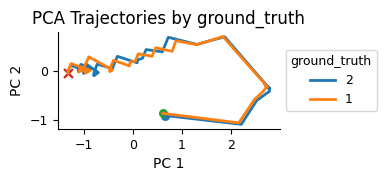

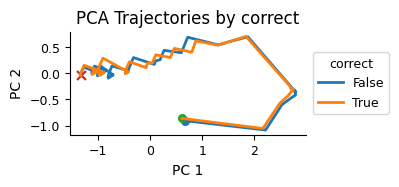

ground_truth    2
coh             5
sigma           1
correct         2
choice          1
dtype: int64


In [ ]:
# @title
# Run analysis charts
analysis_average_activity(activity_by_m=activity_by_model["task2_lstm"], info=info, config=config, savepath=figpath)

analysis_activity_by_condition(activity_by_model["task2_lstm"], info, config, savepath=figpath)

analysis_example_units_by_condition(activity_by_model["task2_lstm"], info, config, savepath=figpath)

analysis_pca_by_condition(activity_by_model["task2_lstm"], info, config, savepath=figpath)

print(info.nunique())




### **TASK 2 LSTM with L2 regularisation**

### TASK 2 LSTM with L2 - Train network


In [ ]:
dataset = None
net = None
activity = None
info = None
torch.cuda.empty_cache()

envid = 'PerceptualDecisionMakingDelayResponse-v0'
model_tag = "task2_lstm_plusL2"
figpath = "./task 2 lstm + L2/"
os.makedirs(figpath, exist_ok=True)

modelpath = get_modelpath(envid, model_tag)
config = {
    'dt': 100,
    'hidden_size': 64,
    'lr': 1e-2,
    'batch_size': 16,
    'seq_len': 100,
    'envid': envid,
    'lambda_rate': 1e-3,     # <<< NEW: regularisation strength
}

env_kwargs = {'dt': config['dt']}
config['env_kwargs'] = env_kwargs

# Save config (important for reproducibility)
with open(modelpath / 'config.json', 'w') as f:
    json.dump(config, f)

# Make supervised dataset
dataset = ngym.Dataset(
    envid,
    env_kwargs=env_kwargs,
    batch_size=config['batch_size'],
    seq_len=config['seq_len']
)

env = dataset.env
act_size = env.action_space.n

# Train network
net = LSTM_plain(
    input_size=env.observation_space.shape[0],
    hidden_size=config['hidden_size'],
    output_size=act_size
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = torch.optim.Adam(net.parameters(), lr=config['lr'])

print('Training task ', envid)
print('Using firing-rate L2 regularisation (λ = {})'.format(config['lambda_rate']))

running_loss = 0.0
losses = []
for i in range(2000):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).float().to(device)
    labels = torch.from_numpy(labels.flatten()).long().to(device)

    optimizer.zero_grad()

    outputs, hidden_activity = net(inputs)

    task_loss = criterion(outputs.view(-1, act_size), labels)

    rate_loss = hidden_activity.pow(2).mean()   # <-L2 firing-rate penalty

    loss = task_loss + config['lambda_rate'] * rate_loss

    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    running_loss += loss.item()
    if i % 200 == 199:
        print(
            '{:d} total: {:0.5f} | task: {:0.5f} | rate: {:0.5f}'.format(
                i + 1,
                running_loss / 200,
                task_loss.item(),
                rate_loss.item()
            )
        )
        running_loss = 0.0
        torch.save(net.state_dict(), modelpath / 'net.pth')

# STORE RESULTS ONCE, AFTER TRAINING
losses_by_model[model_tag] = np.array(losses)
nets_by_model[model_tag] = net

print('Finished Training (with firing-rate regularisation)')


Training task  PerceptualDecisionMakingDelayResponse-v0
Using firing-rate L2 regularisation (λ = 0.001)


/usr/local/lib/python3.12/dist-packages/gymnasium/envs/registration.py:481: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['paper_link', 'paper_name', 'tags']
  logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.seed to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.seed` for environment variables or `env.get_wrapper_attr('seed')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.new_trial to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.new_trial` for environment variables or `env.get_wrapper_attr('new_trial')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/core.py:311: UserWarning: WARN: e

200 total: 0.30732 | task: 0.23832 | rate: 0.11644
400 total: 0.24725 | task: 0.27106 | rate: 0.12431
600 total: 0.24646 | task: 0.24181 | rate: 0.11560
800 total: 0.24647 | task: 0.24161 | rate: 0.10308
1000 total: 0.24538 | task: 0.25429 | rate: 0.09556
1200 total: 0.24714 | task: 0.25587 | rate: 0.08681
1400 total: 0.24720 | task: 0.26284 | rate: 0.07901
1600 total: 0.24767 | task: 0.26583 | rate: 0.07151
1800 total: 0.24624 | task: 0.21536 | rate: 0.06472
2000 total: 0.24533 | task: 0.22257 | rate: 0.06006
Finished Training (with firing-rate regularisation)


In [ ]:
def infer_test_timing(env):
    """Infer timing of environment for testing."""
    timing = {}
    for period in env.timing.keys():
        period_times = [env.sample_time(period) for _ in range(100)]
        timing[period] = np.median(period_times)
    return timing

### TASK 2 LSTM with L2 - Run network after training for analysis

In [ ]:
modelpath = get_modelpath(envid, model_tag)
with open(modelpath / 'config.json') as f:
    config = json.load(f)

env_kwargs = config['env_kwargs']

# Run network to get activity and info
# Environment
env = gym.make(envid, **env_kwargs)
env.timing = infer_test_timing(env)
env.reset()

# Instantiate the network and print information
with torch.no_grad():
    net = LSTM_plain(input_size=env.observation_space.shape[0],
              hidden_size=config['hidden_size'],
              output_size=env.action_space.n)
    net = net.to(device)
    net.load_state_dict(torch.load(modelpath / 'net.pth'))

    perf = 0
    num_trial = 100

    activity = list()
    info = pd.DataFrame()

    for i in range(num_trial):
        env.new_trial()
        ob, gt = env.ob, env.gt
        inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
        action_pred, activity_t = net(inputs)

        # Compute performance
        action_pred = action_pred.detach().numpy()

        resp_idx = np.where(gt != -1)[0]
        t_dec = resp_idx[-1]
        choice = action_pred[t_dec, 0].argmax()
        correct = choice == gt[-1]
        # choice = np.argmax(action_pred[-1, 0, :])
        # correct = choice == gt[t_dec]

        # Log trial info
        trial_info = env.trial
        trial_info.update({'correct': correct, 'choice': choice})
        info = pd.concat([info, pd.DataFrame([trial_info])], ignore_index=True)

        # Log stimulus period activity (pad / truncate to fixed length)
        # h = np.array(hidden)[:, 0, :]
        h = activity_t[:, 0, :].cpu().numpy()
        T = h.shape[0]

        if i == 0:
            T_ref = T                # reference length from first trial

        if T < T_ref:
            pad = np.zeros((T_ref - T, h.shape[1]), dtype=h.dtype)
            h = np.vstack([h, pad])
        elif T > T_ref:
            h = h[:T_ref]

        activity.append(h)

    print('Average performance', np.mean(info['correct']))

activity = np.array(activity)
activity_by_model[model_tag] = activity

/usr/local/lib/python3.12/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.timing to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.timing` for environment variables or `env.get_wrapper_attr('timing')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.sample_time to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.sample_time` for environment variables or `env.get_wrapper_attr('sample_time')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.new_trial to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.new_trial` for environment variables or `env.get_wrapper_attr('new_tri

Average performance 0.55


### TASK 2 LSTM with L2 - Run charts

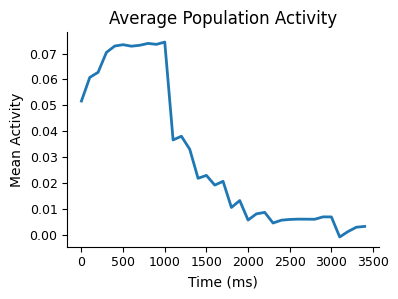

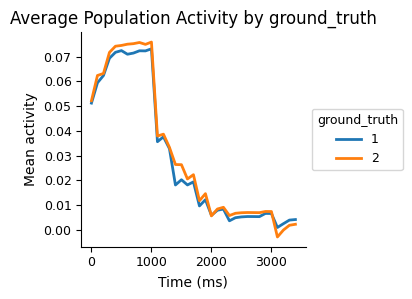

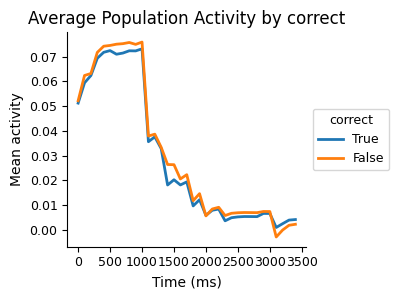

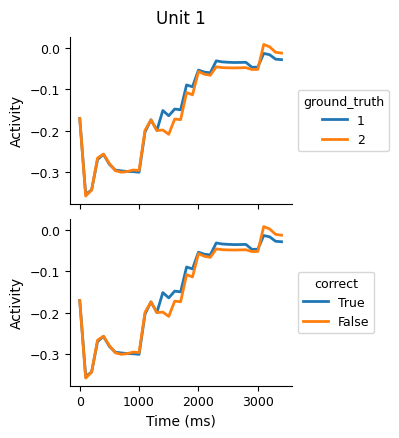

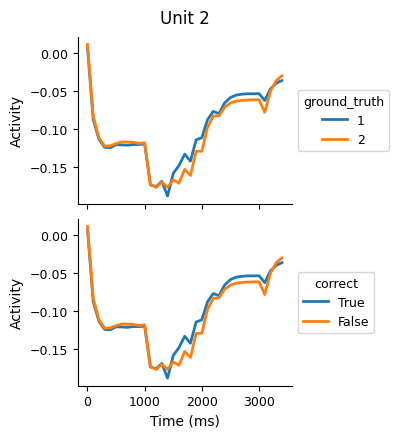

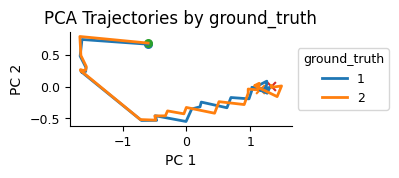

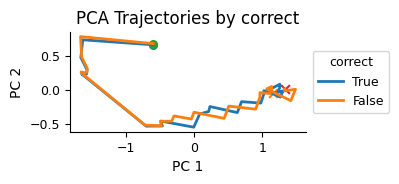

In [ ]:
# Run analysis charts
analysis_average_activity(activity_by_m=activity_by_model["task2_lstm_plusL2"], info=info, config=config, savepath=figpath)

analysis_activity_by_condition(activity_by_model["task2_lstm_plusL2"], info, config, savepath=figpath)

analysis_example_units_by_condition(activity_by_model["task2_lstm_plusL2"], info, config, savepath=figpath)

analysis_pca_by_condition(activity_by_model["task2_lstm_plusL2"], info, config, savepath=figpath)

In [ ]:
print(np.mean(np.abs(activity_by_model["task1_lstm"])))
print(np.mean(np.abs(activity_by_model["task1_lstm_plusL2"])))
print(np.mean(np.abs(activity_by_model["task2_lstm"])))
print(np.mean(np.abs(activity_by_model["task2_lstm_plusL2"])))


0.20111491
0.15920414
0.15583645
0.1869817



# **TASK 2 LSTM ADAPTED MEMORY**

***TASK 2 LSTM ADAPTED MEMORY***

Create a new model object with separate fast and slow memory gates

In [ ]:
class LSTM_AM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, alpha=0.03):
        super(LSTM_AM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)
        self.alpha = alpha

    def forward(self, x):
        h_fast, _ = self.lstm(x)
        h_slow = torch.zeros_like(h_fast[0:1])
        h_slow_seq = []

        for t in range(h_fast.size(0)):
            h_slow = (1 - self.alpha) * h_slow + self.alpha * h_fast[t:t+1]
            h_slow_seq.append(h_slow)

        h_slow = torch.cat(h_slow_seq, dim=0)
        out = self.linear(h_slow)

        return out, h_slow


### TASK 2 LSTM ADAPTED MEMORY - Train network


In [ ]:
dataset = None
net = None
activity = None
info = None
torch.cuda.empty_cache()

envid = 'PerceptualDecisionMakingDelayResponse-v0'
model_tag = "task2_lstm_AM"
figpath = "./task 2 lstm AM"
os.makedirs(figpath, exist_ok=True)

modelpath = get_modelpath(envid, model_tag)
config = {
    'dt': 100,
    'hidden_size': 64,
    'lr': 1e-2,
    'batch_size': 16,
    'seq_len': 100,
    'envid': envid,
}

env_kwargs = {'dt': config['dt']}
config['env_kwargs'] = env_kwargs

# Save config
with open(modelpath / 'config.json', 'w') as f:
    json.dump(config, f)

# Make supervised dataset
dataset = ngym.Dataset(
    envid, env_kwargs=env_kwargs, batch_size=config['batch_size'],
    seq_len=config['seq_len'])
env = dataset.env
act_size = env.action_space.n
# Train network
net = LSTM_AM(input_size=env.observation_space.shape[0],
          hidden_size=config['hidden_size'],
          output_size=act_size)
net = net.to(device)
criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = torch.optim.Adam(net.parameters(), lr=config['lr'])

print('Training task ', envid)

running_loss = 0.0
losses = []
for i in range(2000):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float).to(device)
    labels = torch.from_numpy(labels.flatten()).type(torch.long).to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs, hidden = net(inputs)


    task_loss = criterion(outputs.view(-1, act_size), labels)
    rate_loss = outputs.pow(2).mean()   # logged only
    loss = task_loss
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    # print statistics
    running_loss += loss.item()
    if i % 200 == 199:
      print(
        '{:d} loss: {:0.5f} | task: {:0.5f} | rate: {:0.5f}'.format(
                i + 1,
                running_loss / 200,
                task_loss.item(),
                rate_loss.item()
        )
      )
      running_loss = 0.0
      torch.save(net.state_dict(), modelpath / 'net.pth')

# STORE RESULTS ONCE, AFTER TRAINING
losses_by_model[model_tag] = np.array(losses)
nets_by_model[model_tag] = net

print('Finished Training')

Training task  PerceptualDecisionMakingDelayResponse-v0


/usr/local/lib/python3.12/dist-packages/gymnasium/envs/registration.py:481: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['paper_link', 'paper_name', 'tags']
  logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.seed to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.seed` for environment variables or `env.get_wrapper_attr('seed')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.new_trial to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.new_trial` for environment variables or `env.get_wrapper_attr('new_trial')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/core.py:311: UserWarning: WARN: e

200 loss: 0.62351 | task: 0.38123 | rate: 3.31470
400 loss: 0.33454 | task: 0.28567 | rate: 5.31863
600 loss: 0.24210 | task: 0.21279 | rate: 8.78143
800 loss: 0.20925 | task: 0.21325 | rate: 11.92189
1000 loss: 0.19220 | task: 0.16535 | rate: 14.52795
1200 loss: 0.17652 | task: 0.18833 | rate: 16.08714
1400 loss: 0.16749 | task: 0.16961 | rate: 18.89718
1600 loss: 0.15972 | task: 0.17539 | rate: 19.82765
1800 loss: 0.15650 | task: 0.14989 | rate: 22.30417
2000 loss: 0.14772 | task: 0.13350 | rate: 22.97902
Finished Training


In [ ]:
def infer_test_timing(env):
    """Infer timing of environment for testing."""
    timing = {}
    for period in env.timing.keys():
        period_times = [env.sample_time(period) for _ in range(100)]
        timing[period] = np.median(period_times)
    return timing


### TASK 2 LSTM - Run network after training for analysis

In [ ]:
modelpath = get_modelpath(envid, model_tag)
with open(modelpath / 'config.json') as f:
    config = json.load(f)

env_kwargs = config['env_kwargs']

# Run network to get activity and info
# Environment
env = gym.make(envid, **env_kwargs)
env.timing = infer_test_timing(env)
env.reset()

# Instantiate the network and print information
with torch.no_grad():
    net = LSTM_AM(input_size=env.observation_space.shape[0],
              hidden_size=config['hidden_size'],
              output_size=env.action_space.n)
    net = net.to(device)
    net.load_state_dict(torch.load(modelpath / 'net.pth'))

    perf = 0
    num_trial = 100

    activity = list()
    info = pd.DataFrame()

    for i in range(num_trial):
        env.new_trial()
        ob, gt = env.ob, env.gt
        inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
        action_pred, hidden = net(inputs)

        # Compute performance
        action_pred = action_pred.detach().numpy()
        choice = np.argmax(action_pred[-1, 0, :])
        correct = choice == gt[-1]

        # Log trial info
        trial_info = env.trial
        trial_info.update({'correct': correct, 'choice': choice})
        info = pd.concat([info, pd.DataFrame([trial_info])], ignore_index=True)

        # Log stimulus period activity (pad  to fixed length)
        h = np.array(hidden)[:, 0, :]            # (T, N)
        T =  h.shape[0]

        if i == 0:
            T_ref = T                            # reference length from first trial

        if T < T_ref:
            pad = np.zeros((T_ref - T, h.shape[1]), dtype=h.dtype)
            h = np.vstack([h, pad])
        elif T > T_ref:
            h = h[:T_ref]

        activity.append(h)

    print('Average performance', np.mean(info['correct']))

# # --- FORCE EQUAL TIME LENGTH ACROSS TRIALS ---
# min_T = min(a.shape[0] for a in activity)
# activity = [a[:min_T, :] for a in activity]
activity = np.array(activity)
activity_by_model[model_tag] = activity


/usr/local/lib/python3.12/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.timing to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.timing` for environment variables or `env.get_wrapper_attr('timing')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.sample_time to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.sample_time` for environment variables or `env.get_wrapper_attr('sample_time')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.new_trial to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.new_trial` for environment variables or `env.get_wrapper_attr('new_tri

Average performance 0.89


### TASK 2 LSTM - Run charts

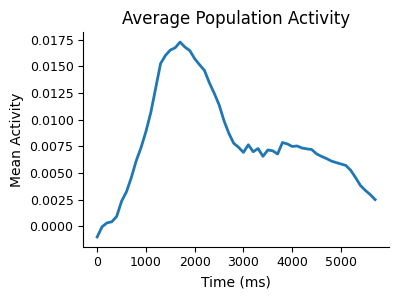

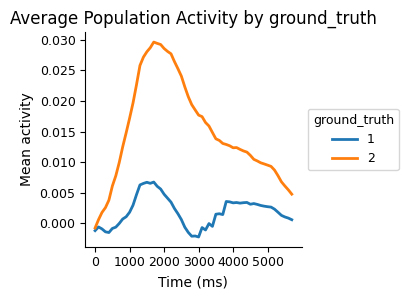

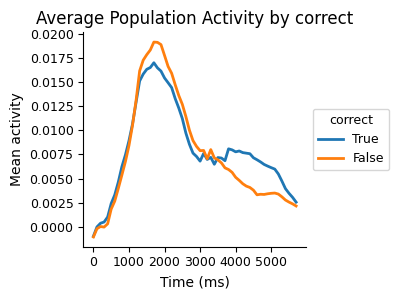

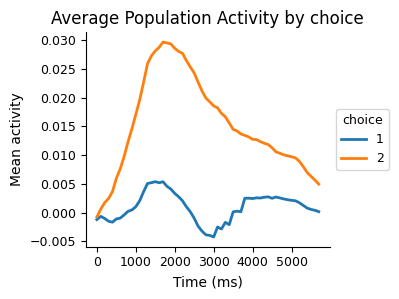

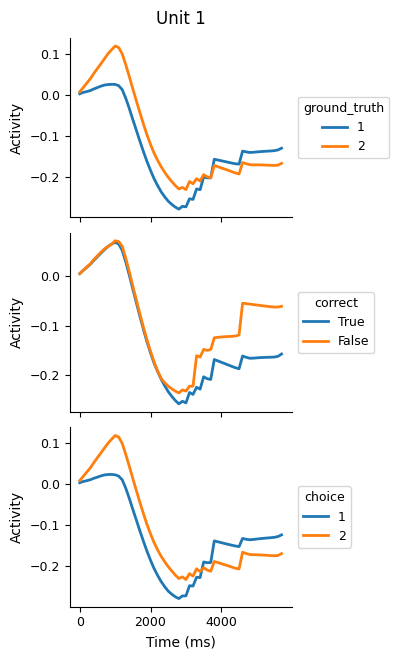

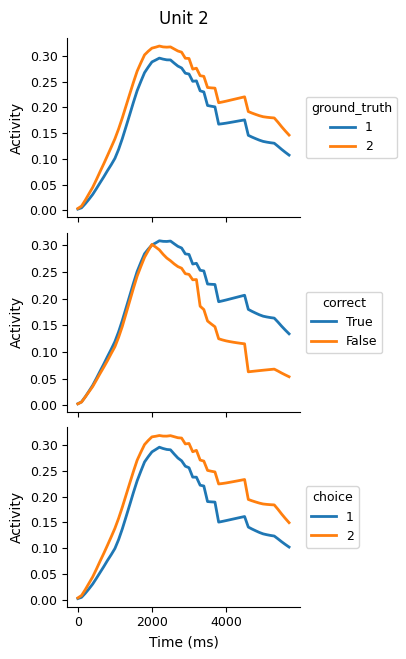

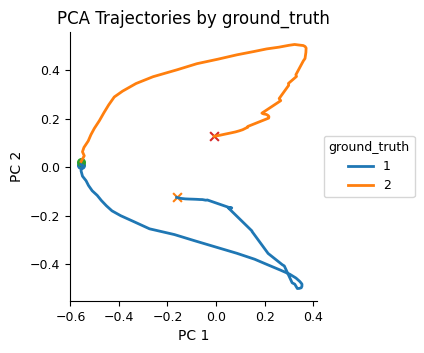

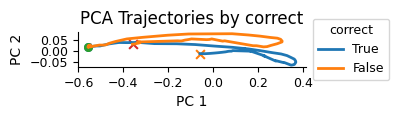

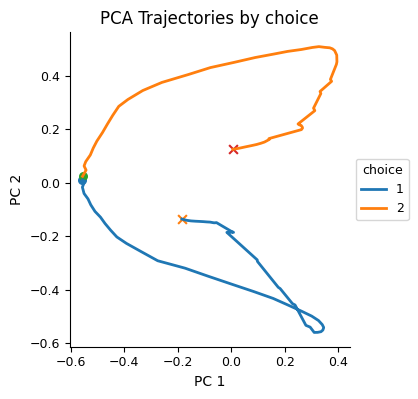

In [ ]:
# Run analysis charts
analysis_average_activity(activity_by_m=activity_by_model["task2_lstm_AM"], info=info, config=config, savepath=figpath)

analysis_activity_by_condition(activity_by_model["task2_lstm_AM"], info, config, savepath=figpath)

analysis_example_units_by_condition(activity_by_model["task2_lstm_AM"], info, config, savepath=figpath)

analysis_pca_by_condition(activity_by_model["task2_lstm_AM"], info, config, savepath=figpath)

### **TASK 2 LSTM with L2 regularisation**

### TASK 2 LSTM with L2 - Train network


In [ ]:
dataset = None
net = None
activity = None
info = None
torch.cuda.empty_cache()

envid = 'PerceptualDecisionMakingDelayResponse-v0'
model_tag = "task2_lstm_plusL2_AM"
figpath = "./task 2 lstm + L2 AM/"
os.makedirs(figpath, exist_ok=True)

"""
Supervised training networks WITH firing-rate regularisation.

Save network in a path determined by environment ID.

Args:
    envid: str, environment ID.
"""
modelpath = get_modelpath(envid, model_tag)
config = {
    'dt': 100,
    'hidden_size': 64,
    'lr': 1e-2,
    'batch_size': 16,
    'seq_len': 100,
    'envid': envid,
    'lambda_rate': 1e-3,     # <<< NEW: regularisation strength
}

env_kwargs = {'dt': config['dt']}
config['env_kwargs'] = env_kwargs

# Save config (important for reproducibility)
with open(modelpath / 'config.json', 'w') as f:
    json.dump(config, f)

# Make supervised dataset
dataset = ngym.Dataset(
    envid,
    env_kwargs=env_kwargs,
    batch_size=config['batch_size'],
    seq_len=config['seq_len']
)

env = dataset.env
act_size = env.action_space.n

# Train network
net = LSTM_AM(
    input_size=env.observation_space.shape[0],
    hidden_size=config['hidden_size'],
    output_size=act_size
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=config['lr'])

print('Training task ', envid)
print('Using firing-rate L2 regularisation (λ = {})'.format(config['lambda_rate']))

running_loss = 0.0
losses = []
for i in range(2000):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).float().to(device)
    labels = torch.from_numpy(labels.flatten()).long().to(device)

    optimizer.zero_grad()

    # Forward pass
    outputs, hidden_activity = net(inputs)   # <- CHANGED: capture activity

    # Task loss
    task_loss = criterion(outputs.view(-1, act_size), labels)

    # Firing-rate L2 regularisation
    rate_loss = hidden_activity.pow(2).mean()   # <<< NEW

    # Total loss
    loss = task_loss + config['lambda_rate'] * rate_loss   # <<< NEW

    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    running_loss += loss.item()
    if i % 200 == 199:
        print(
            '{:d} total: {:0.5f} | task: {:0.5f} | rate: {:0.5f}'.format(
                i + 1,
                running_loss / 200,
                task_loss.item(),
                rate_loss.item()
            )
        )
        running_loss = 0.0
        torch.save(net.state_dict(), modelpath / 'net.pth')

# STORE RESULTS ONCE, AFTER TRAINING
losses_by_model[model_tag] = np.array(losses)
nets_by_model[model_tag] = net

print('Finished Training (with firing-rate regularisation)')


/usr/local/lib/python3.12/dist-packages/gymnasium/envs/registration.py:481: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['paper_link', 'paper_name', 'tags']
  logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.seed to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.seed` for environment variables or `env.get_wrapper_attr('seed')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.new_trial to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.new_trial` for environment variables or `env.get_wrapper_attr('new_trial')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/core.py:311: UserWarning: WARN: e

Training task  PerceptualDecisionMakingDelayResponse-v0
Using firing-rate L2 regularisation (λ = 0.001)
200 total: 0.69680 | task: 0.45404 | rate: 0.03009
400 total: 0.38157 | task: 0.34153 | rate: 0.02381
600 total: 0.30222 | task: 0.26691 | rate: 0.02178
800 total: 0.23951 | task: 0.16745 | rate: 0.02430
1000 total: 0.20545 | task: 0.21428 | rate: 0.02408
1200 total: 0.19244 | task: 0.21551 | rate: 0.02295
1400 total: 0.18428 | task: 0.14730 | rate: 0.02598
1600 total: 0.16479 | task: 0.16229 | rate: 0.02235
1800 total: 0.15356 | task: 0.14331 | rate: 0.02717
2000 total: 0.14988 | task: 0.10898 | rate: 0.02287
Finished Training (with firing-rate regularisation)


In [ ]:
def infer_test_timing(env):
    """Infer timing of environment for testing."""
    timing = {}
    for period in env.timing.keys():
        period_times = [env.sample_time(period) for _ in range(100)]
        timing[period] = np.median(period_times)
    return timing

### TASK 2 LSTM with L2 - Run network after training for analysis

In [ ]:
"""Run trained networks for analysis.

Args:
    envid: str, Environment ID

Returns:
    activity: a list of activity matrices, each matrix has shape (
    N_time, N_neuron)
    info: pandas dataframe, each row is information of a trial
    config: dict of network, training configurations
"""
modelpath = get_modelpath(envid, model_tag)
with open(modelpath / 'config.json') as f:
    config = json.load(f)

env_kwargs = config['env_kwargs']

# Run network to get activity and info
# Environment
env = gym.make(envid, **env_kwargs)
env.timing = infer_test_timing(env)
env.reset()

# Instantiate the network and print information
with torch.no_grad():
    net = LSTM_AM(input_size=env.observation_space.shape[0],
              hidden_size=config['hidden_size'],
              output_size=env.action_space.n)
    net = net.to(device)
    net.load_state_dict(torch.load(modelpath / 'net.pth'))

    perf = 0
    num_trial = 100

    activity = list()
    info = pd.DataFrame()

    for i in range(num_trial):
        env.new_trial()
        ob, gt = env.ob, env.gt
        inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
        action_pred, hidden = net(inputs)

        # Compute performance
        action_pred = action_pred.detach().numpy()
        choice = np.argmax(action_pred[-1, 0, :])
        correct = choice == gt[-1]

        # Log trial info
        trial_info = env.trial
        trial_info.update({'correct': correct, 'choice': choice})
        info = pd.concat([info, pd.DataFrame([trial_info])], ignore_index=True)

        # Log stimulus period activity (pad / truncate to fixed length)
        h = np.array(hidden)[:, 0, :]            # (T, N)
        T = h.shape[0]

        if i == 0:
            T_ref = T                            # reference length from first trial

        if T < T_ref:
            pad = np.zeros((T_ref - T, h.shape[1]), dtype=h.dtype)
            h = np.vstack([h, pad])
        elif T > T_ref:
            h = h[:T_ref]

        activity.append(h)

    print('Average performance', np.mean(info['correct']))

activity = np.array(activity)
activity_by_model[model_tag] = activity

/usr/local/lib/python3.12/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.timing to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.timing` for environment variables or `env.get_wrapper_attr('timing')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.sample_time to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.sample_time` for environment variables or `env.get_wrapper_attr('sample_time')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.new_trial to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.new_trial` for environment variables or `env.get_wrapper_attr('new_tri

Average performance 0.9


### TASK 2 LSTM with L2 - Run charts

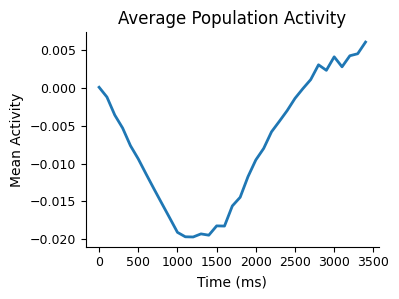

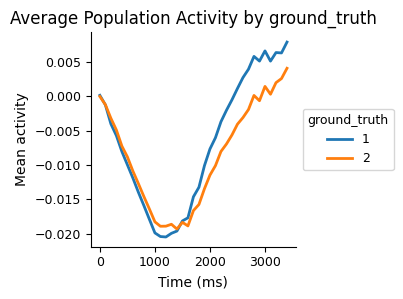

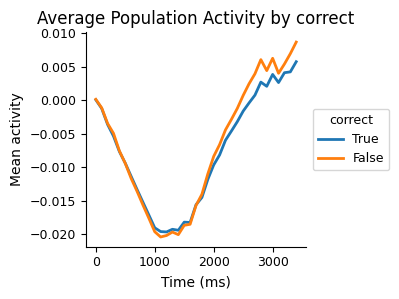

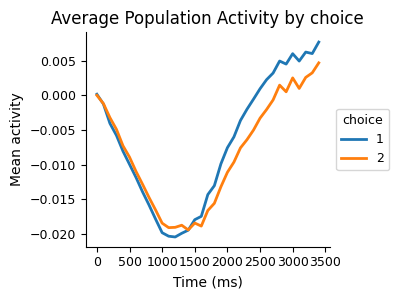

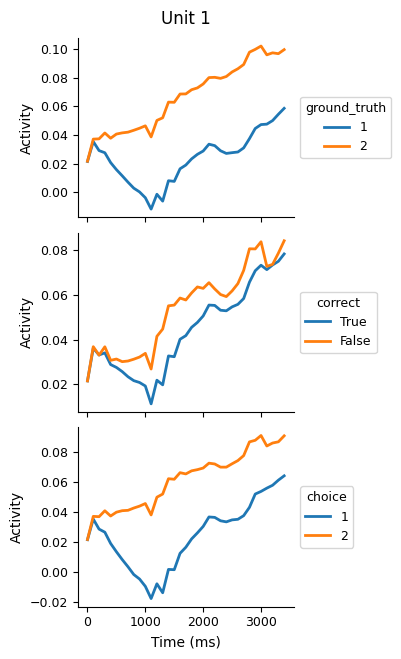

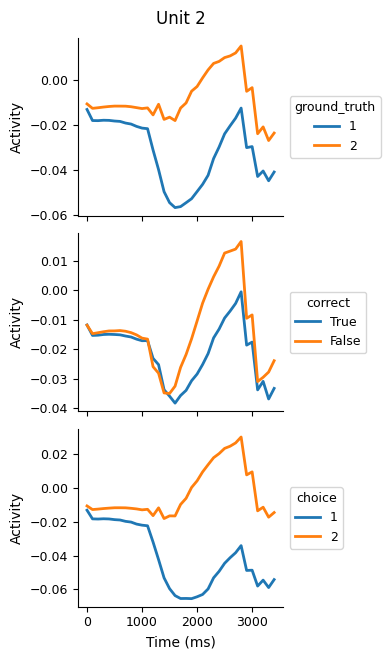

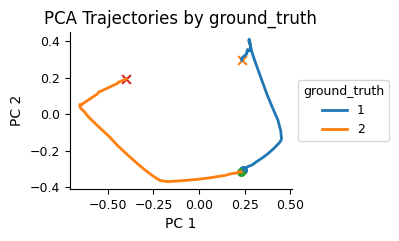

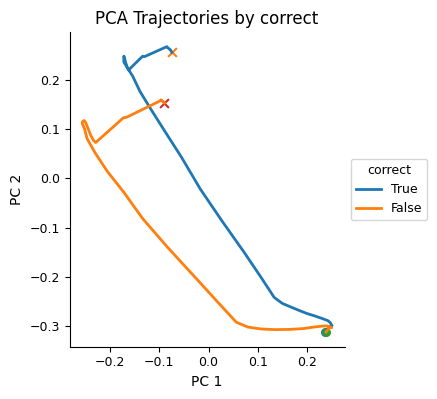

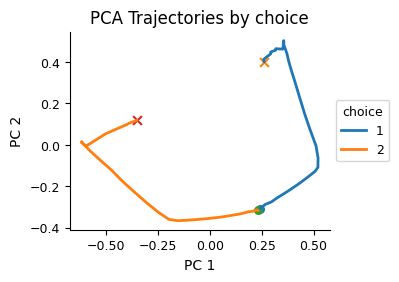

In [ ]:
# Run analysis charts
analysis_average_activity(activity_by_m=activity_by_model["task2_lstm_plusL2_AM"], info=info, config=config, savepath=figpath)

analysis_activity_by_condition(activity_by_model["task2_lstm_plusL2_AM"], info, config, savepath=figpath)

analysis_example_units_by_condition(activity_by_model["task2_lstm_plusL2_AM"], info, config, savepath=figpath)

analysis_pca_by_condition(activity_by_model["task2_lstm_plusL2_AM"], info, config, savepath=figpath)

In [ ]:
print(np.mean(np.abs(activity_by_model["task1_lstm"])))
print(np.mean(np.abs(activity_by_model["task1_lstm_plusL2"])))
print(np.mean(np.abs(activity_by_model["task2_lstm"])))
print(np.mean(np.abs(activity_by_model["task2_lstm_plusL2"])))
print(np.mean(np.abs(activity_by_model["task2_lstm_AM"])))
print(np.mean(np.abs(activity_by_model["task2_lstm_plusL2_AM"])))


0.20111491
0.15920414
0.15583645
0.1869817
0.07877758
0.0773612


In [ ]:
import shutil
import os

def zip_folder(folder_path):
    if not os.path.exists(folder_path):
        print(f"[SKIP] Folder not found: {folder_path}")
        return

    zip_name = folder_path.rstrip("/").replace(" ", "_").replace("+", "")

    shutil.make_archive(
        base_name=zip_name,
        format="zip",
        root_dir=".",
        base_dir=folder_path
    )

    print(f" Created {zip_name}.zip")

zip_folder("task 1 vanilla lstm")
zip_folder("task 1 lstm + L2")
zip_folder("task 2 vanilla lstm")
zip_folder("task 2 lstm + L2")
zip_folder("task 2 lstm AM")
zip_folder("task 2 lstm + L2 AM")

from google.colab import files

for f in [
    "task_1_vanilla_lstm.zip",
    "task_1_lstm__L2.zip",
    "task_2_vanilla_lstm.zip",
    "task_2_lstm__L2.zip",
    "task_2_lstm_AM.zip",
    "task_2_lstm__L2_AM.zip",
]:
    files.download(f)


 Created task_1_vanilla_lstm.zip
 Created task_1_lstm__L2.zip
 Created task_2_vanilla_lstm.zip
 Created task_2_lstm__L2.zip
 Created task_2_lstm_AM.zip
 Created task_2_lstm__L2_AM.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

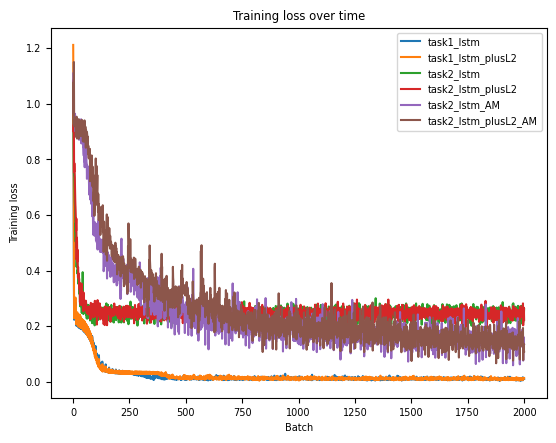

In [ ]:
plot_training_loss(
    losses_by_model,
    ["task1_lstm", "task1_lstm_plusL2", "task2_lstm", "task2_lstm_plusL2", "task2_lstm_AM", "task2_lstm_plusL2_AM"],
    xmax=2000
)


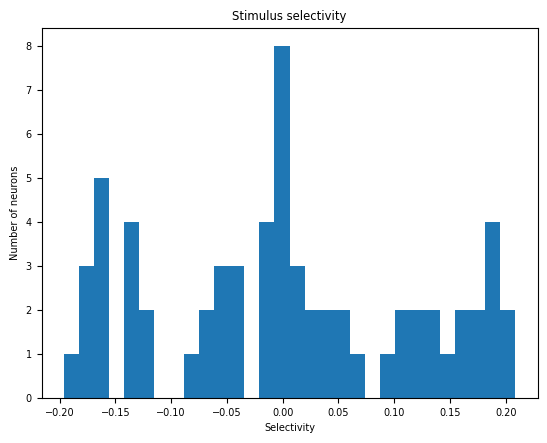

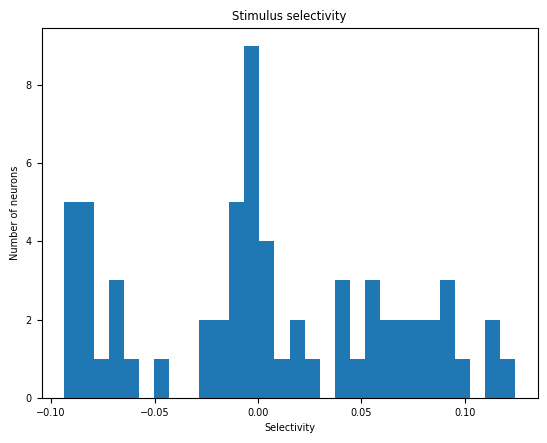

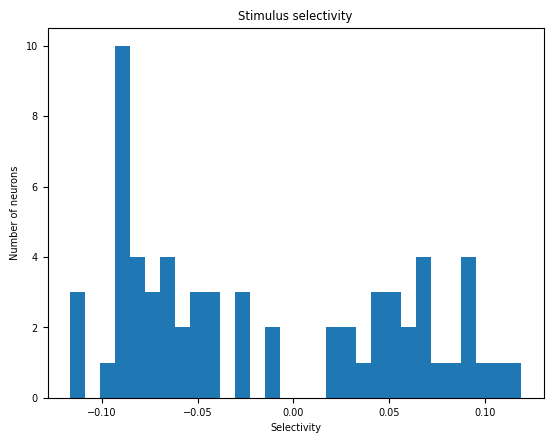

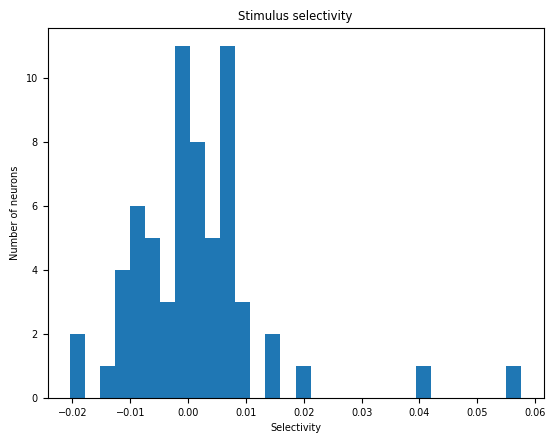

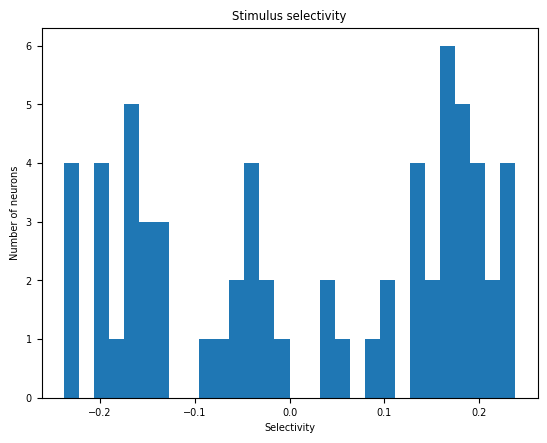

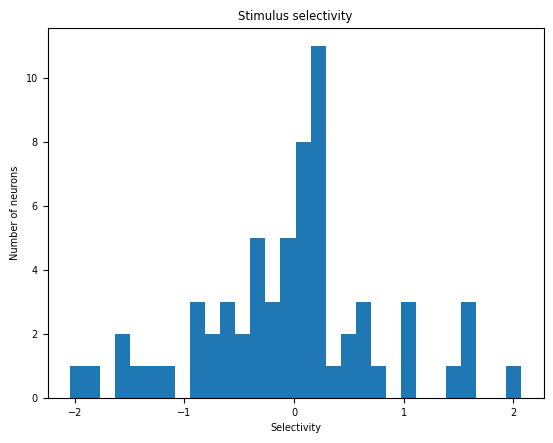

In [ ]:
def build_stim_responses(neural_data, info):
    stim_responses = {}
    for trial_idx in range(len(neural_data)):
        gt = int(info.loc[trial_idx, "ground_truth"])
        stim_responses.setdefault(gt, []).append(neural_data[trial_idx])
    return stim_responses


def compute_selectivity(stim_responses):
    mean_resp = []
    std_resp = []

    for gt in sorted(stim_responses.keys()):
        x = np.concatenate(stim_responses[gt], axis=0)
        mean_resp.append(x.mean(axis=0))
        std_resp.append(x.std(axis=0))

    selectivity = mean_resp[0] - mean_resp[1]
    selectivity /= np.sqrt((std_resp[0]**2 + std_resp[1]**2 + 1e-7) / 2)
    return selectivity

def plot_selectivity(selectivity):
    plt.figure()
    plt.hist(selectivity, bins=30)
    plt.xlabel("Selectivity")
    plt.ylabel("Number of neurons")
    plt.title("Stimulus selectivity")
    plt.show()


neural_data = activity_by_model["task1_lstm"]
stim_responses = build_stim_responses(neural_data, info)
selectivity = compute_selectivity(stim_responses)
plot_selectivity(selectivity)

neural_data = activity_by_model["task1_lstm_plusL2"]
stim_responses = build_stim_responses(neural_data, info)
selectivity = compute_selectivity(stim_responses)
plot_selectivity(selectivity)

neural_data = activity_by_model["task2_lstm"]
stim_responses = build_stim_responses(neural_data, info)
selectivity = compute_selectivity(stim_responses)
plot_selectivity(selectivity)

neural_data = activity_by_model["task2_lstm_plusL2"]
stim_responses = build_stim_responses(neural_data, info)
selectivity = compute_selectivity(stim_responses)
plot_selectivity(selectivity)

neural_data = activity_by_model["task2_lstm_AM"]
stim_responses = build_stim_responses(neural_data, info)
selectivity = compute_selectivity(stim_responses)
plot_selectivity(selectivity)

neural_data = activity_by_model["task2_lstm_plusL2_AM"]
stim_responses = build_stim_responses(neural_data, info)
selectivity = compute_selectivity(stim_responses)
plot_selectivity(selectivity)

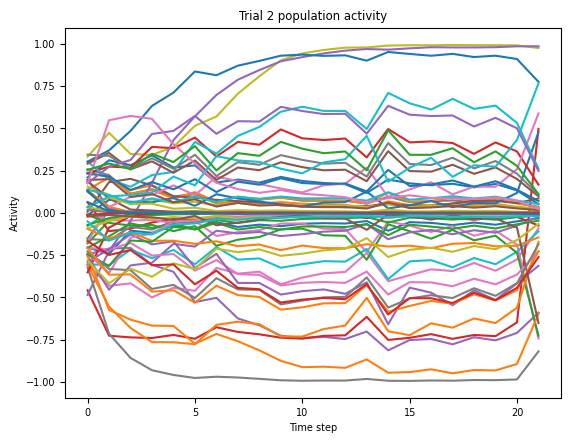

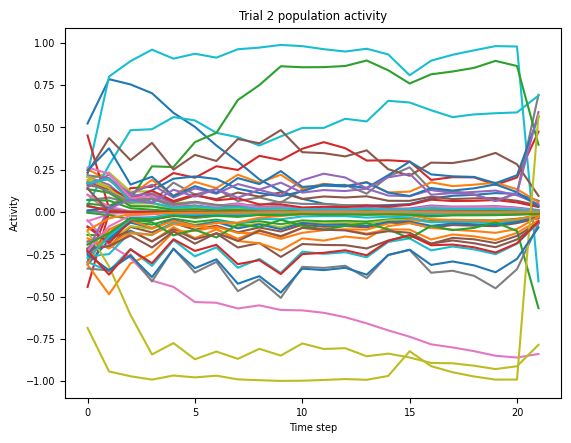

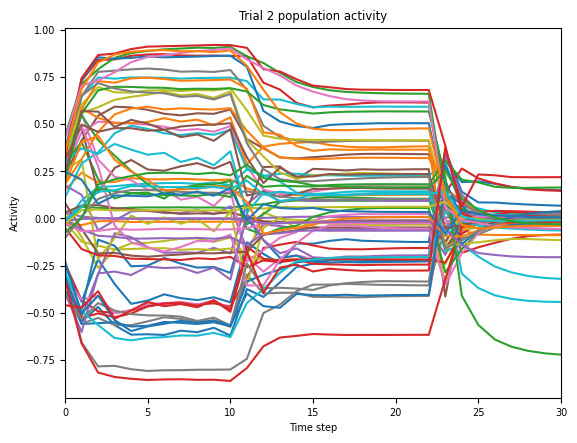

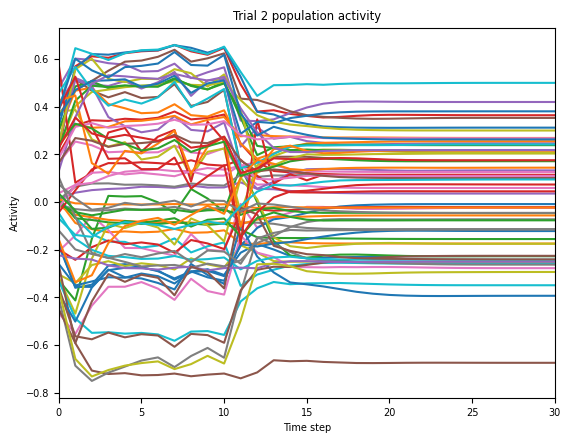

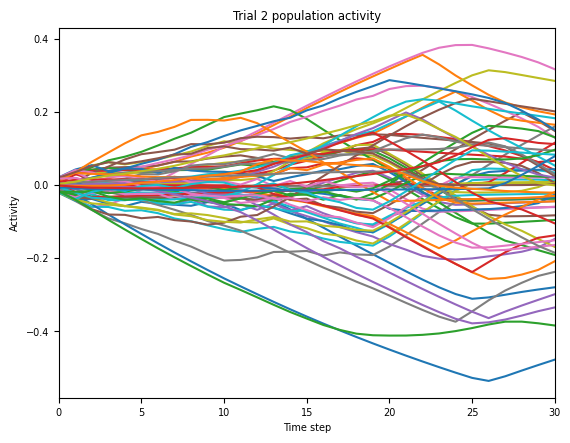

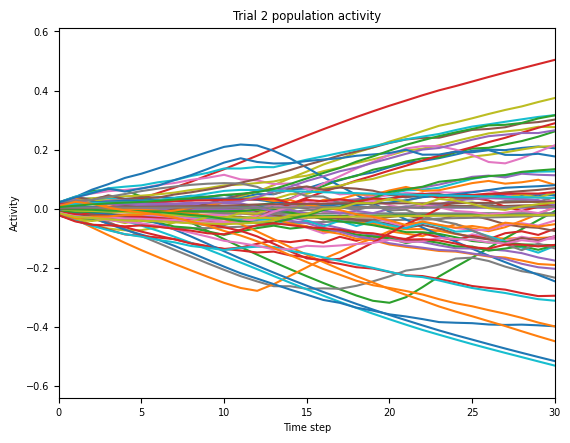

In [ ]:
def plot_sample_activity(activity_to_visualise, trial_idx):
    plt.figure()
    plt.plot(activity_to_visualise[trial_idx])
    plt.xlabel("Time step")
    plt.ylabel("Activity")
    plt.title(f"Trial {trial_idx} population activity")
    plt.show()

def plot_sample_activity30(activity_to_visualise, trial_idx):
    plt.figure()
    plt.plot(activity_to_visualise[trial_idx])
    plt.xlabel("Time step")
    plt.ylabel("Activity")
    plt.title(f"Trial {trial_idx} population activity")
    plt.xlim(0, 30)
    plt.show()

plot_sample_activity(activity_by_model["task1_lstm"], trial_idx=2)
plot_sample_activity(activity_by_model["task1_lstm_plusL2"], trial_idx=2)
plot_sample_activity30(activity_by_model["task2_lstm"], trial_idx=2)
plot_sample_activity30(activity_by_model["task2_lstm_plusL2"], trial_idx=2)
plot_sample_activity30(activity_by_model["task2_lstm_AM"], trial_idx=2)
plot_sample_activity30(activity_by_model["task2_lstm_plusL2_AM"], trial_idx=2)

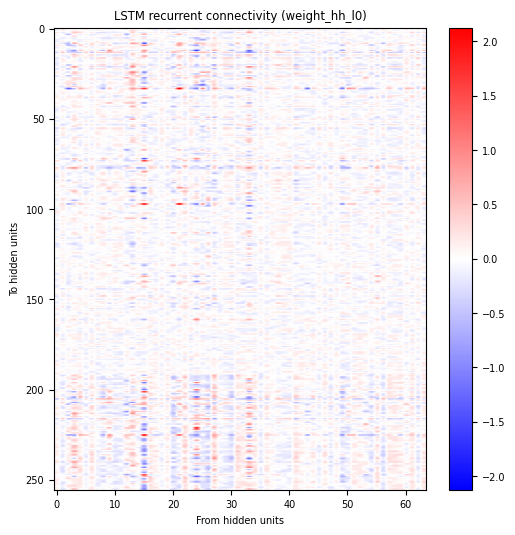

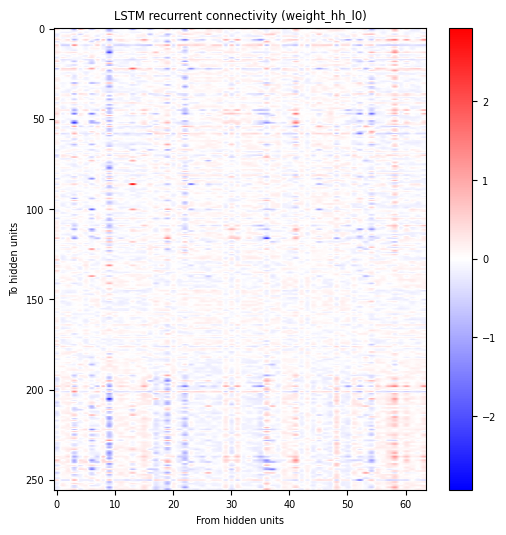

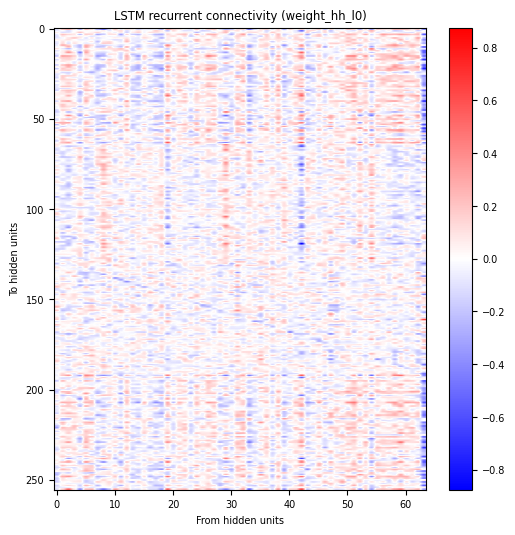

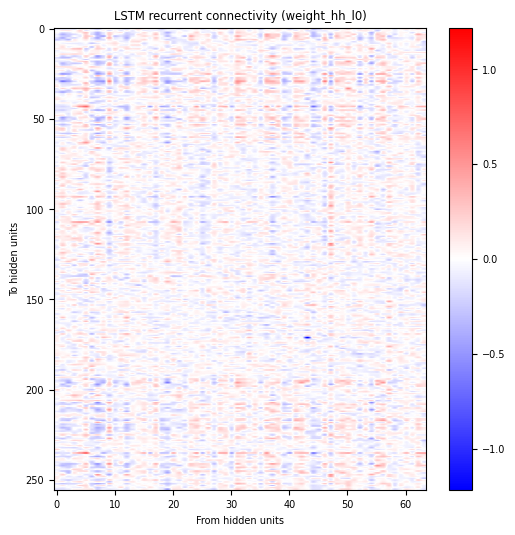

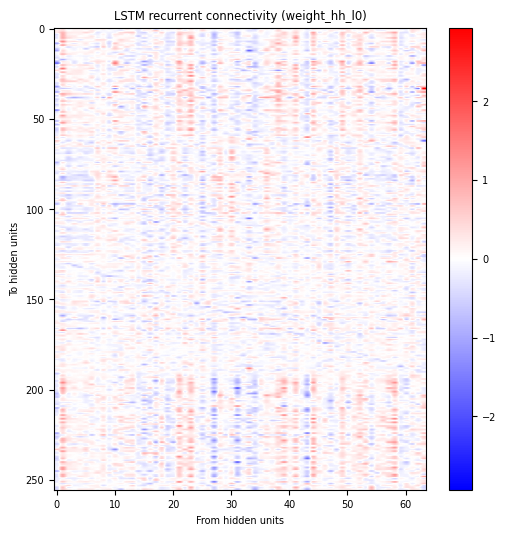

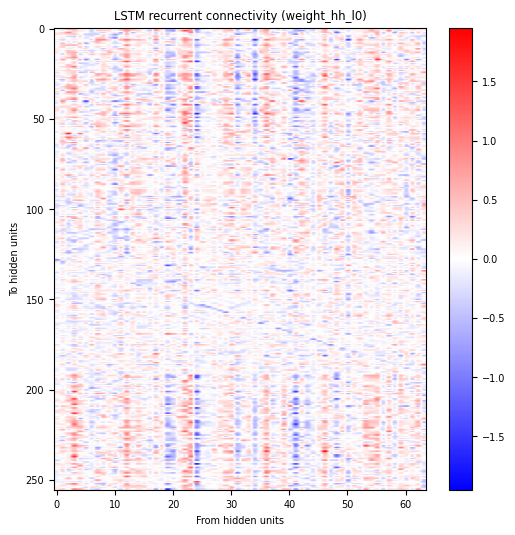

In [ ]:
def plot_connectivity(net):
    W = net.lstm.weight_hh_l0.detach().cpu().numpy()
    wlim = np.max(np.abs(W))
    plt.figure(figsize=(6, 6))
    plt.imshow(W, cmap="bwr", vmin=-wlim, vmax=wlim, aspect="auto")
    plt.colorbar()
    plt.xlabel("From hidden units")
    plt.ylabel("To hidden units")
    plt.title("LSTM recurrent connectivity (weight_hh_l0)")
    plt.show()


plot_connectivity(nets_by_model["task1_lstm"])
plot_connectivity(nets_by_model["task1_lstm_plusL2"])
plot_connectivity(nets_by_model["task2_lstm"])
plot_connectivity(nets_by_model["task2_lstm_plusL2"])
plot_connectivity(nets_by_model["task2_lstm_AM"])
plot_connectivity(nets_by_model["task2_lstm_plusL2_AM"])



/usr/local/lib/python3.12/dist-packages/gymnasium/envs/registration.py:481: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['paper_link', 'paper_name', 'tags']
  logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.rewards to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.rewards` for environment variables or `env.get_wrapper_attr('rewards')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/envs/registration.py:481: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['paper_link', 'paper_name', 'tags']
  logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.rewards to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `

Plotting environment for PerceptualDecisionMaking-v0
Plotting environment for PerceptualDecisionMakingDelayResponse-v0


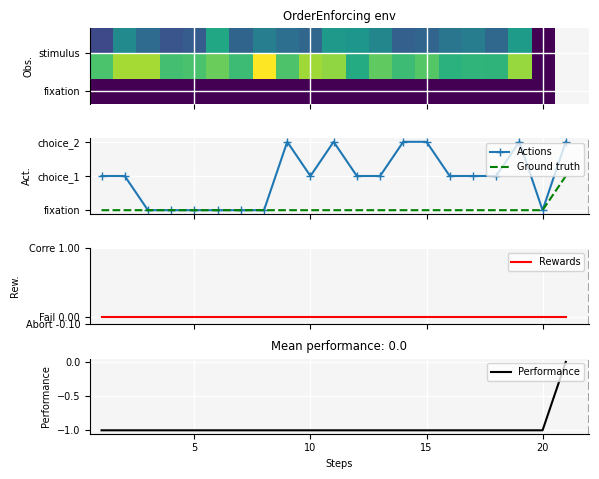

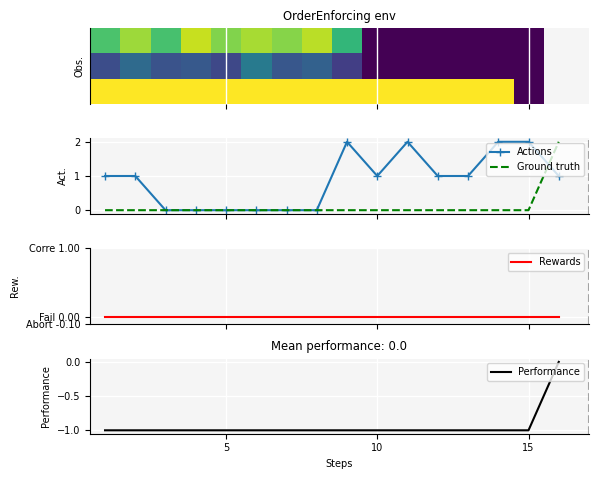

In [ ]:
import neurogym.utils.plotting as ngplot

class DummyVecEnv:
    pass

ngplot.DummyVecEnv = DummyVecEnv

envid = "PerceptualDecisionMaking-v0"
env = gym.make(envid, **env_kwargs)

print(f"Plotting environment for {envid}")
_ = ngym.utils.plot_env(env, num_trials=1)

envid = "PerceptualDecisionMakingDelayResponse-v0"
env = gym.make(envid, **env_kwargs)

print(f"Plotting environment for {envid}")
_ = ngym.utils.plot_env(env, num_trials=1)
